In [ ]:
'''
Data Collection and Pre-processing
  1. Dataset used - https://ocr-vqa.github.io/
  2. Steps Followed:
    2.1 Data Loading
    2.2 Text Extraction from Images   - OCR to extract text from images
    2.3 Image Summarization           - To generate a brief summary or caption for the images
    2.4 QA Pairs and MCQ Generation   - Format the extracted text and summaries into QA pairs
    2.5 Data Structuring              - To a format that can be easily integrated into a MuRAG pipeline
'''

'\nData Collection and Pre-processing\n  1. Dataset used - https://ocr-vqa.github.io/\n  2. Steps Followed:\n    2.1 Data Loading\n    2.2 Text Extraction from Images   - OCR to extract text from images\n    2.3 Image Summarization           - To generate a brief summary or caption for the images\n    2.4 QA Pairs and MCQ Generation   - Format the extracted text and summaries into QA pairs\n    2.5 Data Structuring              - To a format that can be easily integrated into a MuRAG pipeline\n'

**1. Data Collection and Pre-processing**

In [ ]:
!apt-get install tesseract-ocr

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done


The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (8,119 kB/s)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-eng_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-eng (1:4.00~git30-7274cfa-1.1) ...


Selecting previously unselected package tesseract-ocr-osd.
Preparing to unpack .../tesseract-ocr-osd_1%3a4.00~git30-7274cfa-1.1_all.deb ...
Unpacking tesseract-ocr-osd (1:4.00~git30-7274cfa-1.1) ...
Selecting previously unselected package tesseract-ocr.
Preparing to unpack .../tesseract-ocr_4.1.1-2.1build1_amd64.deb ...
Unpacking tesseract-ocr (4.1.1-2.1build1) ...
Setting up tesseract-ocr-eng (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr-osd (1:4.00~git30-7274cfa-1.1) ...
Setting up tesseract-ocr (4.1.1-2.1build1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
import json
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import pytesseract
from transformers import pipeline
from tqdm import tqdm
import os
from concurrent.futures import ThreadPoolExecutor
import logging
import numpy as np

class MuRAGPreprocessor:
    def __init__(self, json_path, image_save_dir='processed_images', batch_size=32):
        """
        Initialize the MuRAG preprocessor

        Args:
            json_path (str): Path to the OCR-VQA dataset JSON file
            image_save_dir (str): Directory to save downloaded images
            batch_size (int): Batch size for processing
        """
        self.json_path = json_path
        self.image_save_dir = image_save_dir
        self.batch_size = batch_size
        self.image_captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
        os.makedirs(image_save_dir, exist_ok=True)

    def load_data(self):
        """Load and perform initial parsing of the dataset"""
        try:
            with open(self.json_path, 'r') as f:
                self.raw_data = json.load(f)
            self.logger.info(f"Successfully loaded {len(self.raw_data)} items from dataset")
            return True
        except Exception as e:
            self.logger.error(f"Error loading data: {str(e)}")
            return False

    def download_image(self, image_id, url):
        """Download and save an image from URL"""
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                img_path = os.path.join(self.image_save_dir, f"{image_id}.jpg")
                Image.open(BytesIO(response.content)).save(img_path)
                return img_path
            return None
        except Exception as e:
            self.logger.warning(f"Failed to download image {image_id}: {str(e)}")
            return None

    def extract_text_from_image(self, image_path):
        """Extract text from image using OCR"""
        try:
            if image_path and os.path.exists(image_path):
                img = Image.open(image_path)
                text = pytesseract.image_to_string(img)
                return text.strip()
            return ""
        except Exception as e:
            self.logger.warning(f"OCR failed for {image_path}: {str(e)}")
            return ""

    def generate_image_summary(self, image_path):
        """Generate a caption/summary for the image"""
        try:
            if image_path and os.path.exists(image_path):
                image = Image.open(image_path)
                caption = self.image_captioner(image)[0]['generated_text']
                return caption
            return ""
        except Exception as e:
            self.logger.warning(f"Caption generation failed for {image_path}: {str(e)}")
            return ""

    def generate_mcq(self, correct_answer, context):
        """Generate MCQ options including the correct answer"""
        options = [correct_answer]
        other_answers = [
            ans for ans in set(context['answers'])
            if ans != correct_answer
        ]
        options.extend(np.random.choice(other_answers, min(3, len(other_answers)), replace=False))
        while len(options) < 4:
            options.append(f"None of the above {len(options)}")
        return options

    def process_item(self, item_id, item_data):
        """Process a single dataset item"""
        try:
            image_path = self.download_image(item_id, item_data['imageURL'])
            if not image_path:
                return None
            ocr_text = self.extract_text_from_image(image_path)
            image_summary = self.generate_image_summary(image_path)
            qa_pairs = []
            for q, a in zip(item_data['questions'], item_data['answers']):
                qa_pair = {
                    'question': q,
                    'answer': a,
                    'options': self.generate_mcq(a, item_data),
                    'context': {
                        'ocr_text': ocr_text,
                        'image_summary': image_summary,
                        'title': item_data.get('title', ''),
                        'author': item_data.get('authorName', ''),
                        'genre': item_data.get('genre', ''),
                        'image_path': image_path
                    }
                }
                qa_pairs.append(qa_pair)

            return qa_pairs

        except Exception as e:
            self.logger.error(f"Error processing item {item_id}: {str(e)}")
            return None

    def process_dataset(self):
        """Process the entire dataset"""
        processed_data = []

        with ThreadPoolExecutor(max_workers=4) as executor:
            future_to_id = {
                executor.submit(self.process_item, item_id, item_data): item_id
                for item_id, item_data in self.raw_data.items()
            }

            for future in tqdm(future_to_id, desc="Processing items"):
                item_id = future_to_id[future]
                try:
                    result = future.result()
                    if result:
                        processed_data.extend(result)
                except Exception as e:
                    self.logger.error(f"Failed to process item {item_id}: {str(e)}")
        self.save_processed_data(processed_data)
        return processed_data

    def save_processed_data(self, processed_data):
        """Save the processed dataset"""
        try:
            with open('processed_murag_data.json', 'w') as f:
                json.dump(processed_data, f)
            df = pd.DataFrame(processed_data)
            df.to_csv('processed_murag_data.csv', index=False)

            self.logger.info(f"Successfully saved {len(processed_data)} processed items")
        except Exception as e:
            self.logger.error(f"Error saving processed data: {str(e)}")

def main():
    preprocessor = MuRAGPreprocessor(
        json_path='/content/dataset.json',
        image_save_dir='processed_images',
        batch_size=32
    )

    if preprocessor.load_data():
        processed_data = preprocessor.process_dataset()
        print(f"Successfully processed {len(processed_data)} QA pairs")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Processing items:   0%|          | 0/207572 [00:00<?, ?it/s]

In [ ]:
import json
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import pytesseract
from transformers import pipeline
from tqdm import tqdm
import os
from concurrent.futures import ThreadPoolExecutor
import logging
import numpy as np

class MuRAGPreprocessor:
    def __init__(self, json_path, image_save_dir='processed_images', batch_size=32, max_items=None):
        """
        Initialize the MuRAG preprocessor

        Args:
            json_path (str): Path to the OCR-VQA dataset JSON file
            image_save_dir (str): Directory to save downloaded images
            batch_size (int): Batch size for processing
            max_items (int): Maximum number of items to process (default is None for all)
        """
        self.json_path = json_path
        self.image_save_dir = image_save_dir
        self.batch_size = batch_size
        self.max_items = max_items
        self.image_captioner = pipeline("image-to-text", model="Salesforce/blip-image-captioning-base")
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s'
        )
        self.logger = logging.getLogger(__name__)
        os.makedirs(image_save_dir, exist_ok=True)

    def load_data(self):
        """Load and perform initial parsing of the dataset"""
        try:
            with open(self.json_path, 'r') as f:
                self.raw_data = json.load(f)
            if self.max_items:
                self.raw_data = dict(list(self.raw_data.items())[:self.max_items])

            self.logger.info(f"Successfully loaded {len(self.raw_data)} items from dataset")
            return True
        except Exception as e:
            self.logger.error(f"Error loading data: {str(e)}")
            return False

    def download_image(self, image_id, url):
        """Download and save an image from URL"""
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                img_path = os.path.join(self.image_save_dir, f"{image_id}.jpg")
                Image.open(BytesIO(response.content)).save(img_path)
                return img_path
            return None
        except Exception as e:
            self.logger.warning(f"Failed to download image {image_id}: {str(e)}")
            return None

    def extract_text_from_image(self, image_path):
        """Extract text from image using OCR"""
        try:
            if image_path and os.path.exists(image_path):
                img = Image.open(image_path)
                text = pytesseract.image_to_string(img)
                return text.strip()
            return ""
        except Exception as e:
            self.logger.warning(f"OCR failed for {image_path}: {str(e)}")
            return ""

    def generate_image_summary(self, image_path):
        """Generate a caption/summary for the image"""
        try:
            if image_path and os.path.exists(image_path):
                image = Image.open(image_path)
                caption = self.image_captioner(image)[0]['generated_text']
                return caption
            return ""
        except Exception as e:
            self.logger.warning(f"Caption generation failed for {image_path}: {str(e)}")
            return ""

    def generate_mcq(self, correct_answer, context):
        """Generate MCQ options including the correct answer"""
        options = [correct_answer]
        other_answers = [
            ans for ans in set(context['answers'])
            if ans != correct_answer
        ]
        options.extend(np.random.choice(other_answers, min(3, len(other_answers)), replace=False))
        while len(options) < 4:
            options.append(f"None of the above {len(options)}")
        return options

    def process_item(self, item_id, item_data):
        """Process a single dataset item"""
        try:
            image_path = self.download_image(item_id, item_data['imageURL'])
            if not image_path:
                return None
            ocr_text = self.extract_text_from_image(image_path)
            image_summary = self.generate_image_summary(image_path)
            qa_pairs = []
            for q, a in zip(item_data['questions'], item_data['answers']):
                qa_pair = {
                    'question': q,
                    'answer': a,
                    'options': self.generate_mcq(a, item_data),
                    'context': {
                        'ocr_text': ocr_text,
                        'image_summary': image_summary,
                        'title': item_data.get('title', ''),
                        'author': item_data.get('authorName', ''),
                        'genre': item_data.get('genre', ''),
                        'image_path': image_path
                    }
                }
                qa_pairs.append(qa_pair)

            return qa_pairs

        except Exception as e:
            self.logger.error(f"Error processing item {item_id}: {str(e)}")
            return None

    def process_dataset(self):
        """Process the entire dataset"""
        processed_data = []

        with ThreadPoolExecutor(max_workers=4) as executor:
            future_to_id = {
                executor.submit(self.process_item, item_id, item_data): item_id
                for item_id, item_data in self.raw_data.items()
            }

            for future in tqdm(future_to_id, desc="Processing items"):
                item_id = future_to_id[future]
                try:
                    result = future.result()
                    if result:
                        processed_data.extend(result)
                except Exception as e:
                    self.logger.error(f"Failed to process item {item_id}: {str(e)}")
        self.save_processed_data(processed_data)
        return processed_data

    def save_processed_data(self, processed_data):
        """Save the processed dataset"""
        try:
            with open('processed_murag_data.json', 'w') as f:
                json.dump(processed_data, f)
            df = pd.DataFrame(processed_data)
            df.to_csv('processed_murag_data.csv', index=False)

            self.logger.info(f"Successfully saved {len(processed_data)} processed items")
        except Exception as e:
            self.logger.error(f"Error saving processed data: {str(e)}")

def main():
    preprocessor = MuRAGPreprocessor(
        json_path='/content/dataset.json',
        image_save_dir='processed_images2',
        batch_size=32,
        max_items=50
    )

    if preprocessor.load_data():
        processed_data = preprocessor.process_dataset()
        print(f"Successfully processed {len(processed_data)} QA pairs")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Processing items:   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Processing items:   2%|▏         | 1/50 [01:12<58:56, 72.17s/it]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_

Successfully processed 267 QA pairs


In [ ]:
!pip install torch torchvision transformers datasets faiss-cpu


In [ ]:
import os
import json
import pandas as pd
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class MuRAGDataset(Dataset):
    def __init__(self, data_file, image_transform=None):
        self.data = pd.read_json(data_file)  # Assuming processed data is in JSON format
        self.image_transform = image_transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image_path = item['context']['image_path']
        image = Image.open(image_path)

        if self.image_transform:
            image = self.image_transform(image)

        return {
            'text': item['question'],
            'image': image,
            'label': item['answer']
        }

# Define image transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for the model
    transforms.ToTensor(),
])

# Create dataset and dataloader
dataset = MuRAGDataset('processed_murag_data.json', image_transform=image_transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Collect all unique labels from your dataset
unique_labels = set()
for idx in range(len(dataset)):
    unique_labels.add(dataset[idx]['label'])

# Print unique labels to verify
print("Unique labels in dataset:", unique_labels)

# Define your label-to-index mapping based on the unique labels
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
print("Label to index mapping:", label_to_index)


Unique labels in dataset: {'Amy Knapp', 'Grumpy Cat 2016 Wall Calendar', 'No', 'Workman Publishing', 'Audubon Engagement Calendar 2016', '2016 Almond Blossoms Weekly Planner (16-Month Engagement Calendar, Diary)', 'Amc', 'Ansel Adams 2016 Wall Calendar', 'MAXINE  Year-In-A-Box Calendar (2016)', '2015', 'Audubon Nature Wall Calendar 2016', 'Mary Engelbreit 2016 Deluxe Wall Calendar: Never Give Up', 'Linda Dannenberg', "Llewellyn's 2016 Witches' Datebook", 'Mary Engelbreit 2016 Monthly Pocket Planner: Just Being ME!', 'Doug the Pug 2016 Wall Calendar', 'Old FarmerEEs Almanac', 'Anne Taintor 2016 Wall Calendar', 'Chihuly 2016 Wall Calendar', 'Nintendo', 'Barbara Ardinger', "Llewellyn's 2016 Witches' Calendar", 'Anne Taintor', 'Dale Chihuly', 'Sierra Club Engagement Calendar 2016', '2016 National Park Foundation Wall Calendar', "Mom's Family Wall Calendar 2016", 'Today Is Going to Be a Great Day! Color Page-A-Day Calendar 2016', 'Moleskine 2015-2016 Weekly Notebook, 18M, Large, Black, Soft

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torchvision import models

class MuRAG(nn.Module):
    def __init__(self, num_classes):
        super(MuRAG, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Identity()  # Remove classification layer

        self.fc = nn.Linear(self.bert.config.hidden_size + 2048, num_classes)  # Combine outputs

    def forward(self, text, images):
        # Tokenize text and get embeddings
        text_inputs = self.bert_tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        text_outputs = self.bert(**text_inputs)
        text_embedding = text_outputs.pooler_output

        # Get image embeddings
        image_embeddings = self.resnet(images)

        # Combine embeddings
        combined = torch.cat((text_embedding, image_embeddings), dim=1)
        output = self.fc(combined)

        return output


In [ ]:
from tqdm import tqdm

def train(model, dataloader, device, epochs=5):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch in tqdm(dataloader):
            text, images, labels = batch['text'], batch['image'].to(device), batch['label']

            # Debug: print labels to check values
            print(f"Batch Labels: {labels}")

            # Normalize and map labels to indices
            labels = [label.strip() for label in labels]  # Clean labels
            labels = torch.tensor([label_to_index.get(label, -1) for label in labels]).to(device)

            # Debug: print mapped labels to check for invalid values
            print(f"Mapped Labels: {labels}")

            # Filter out invalid labels
            valid_mask = labels != -1
            if not valid_mask.any():
                print("Warning: Skipping batch with all invalid labels.")
                continue  # Skip batch with all invalid labels

            # Filter batch based on valid labels
            text = [t for t, valid in zip(text, valid_mask) if valid]
            images = images[valid_mask]
            labels = labels[valid_mask]

            # Forward pass
            outputs = model(text, images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            print(f"Epoch [{epoch + 1}/{epochs}], Batch Loss: {loss.item():.4f}")

        epoch_loss = total_loss / len(dataloader)
        if total > 0:
            accuracy = 100 * correct / total
            print(f"Epoch [{epoch + 1}/{epochs}], Average Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
        else:
            print(f"Epoch [{epoch + 1}/{epochs}], Average Loss: {epoch_loss:.4f}, No valid labels to calculate accuracy.")


In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MuRAG(num_classes=len(label_to_index)).to(device)

# Train the model
train(model, dataloader, device)


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnin

Batch Labels: ['Calendars', '2016', 'No', 'Dog Page-A-Day Gallery Calendar 2016', 'Sandra Boynton', '2016', 'Calendars', 'Yes', 'No', 'Yes', 'No', 'Mary Engelbreit 2016 Deluxe Wall Calendar: Never Give Up', '2016', 'Calendars', 'Calendars', 'Yes', 'Susan Branch', 'Audubon Nature Wall Calendar 2016', '2016', 'No', 'No', '2016', "The Old Farmer's Almanac 2016 Gardening Calendar", 'Audubon Birds Page-A-Day Gallery Calendar 2016', '2016', 'Yes', 'Sierra Club Engagement Calendar 2016', 'Dale Chihuly', 'Mary Engelbreit', '2016', 'No', 'Yes']
Mapped Labels: tensor([63, 38,  2, 37, 77, 38, 63, 50,  2, 50,  2, 11, 38, 63, 63, 50, 74, 10,
        38,  2,  2, 38, 73, 49, 38, 50, 24, 23, 34, 38,  2, 50])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [1/5], Batch Loss: 4.4056
Batch Labels: ['365 New Words-A-Year Page-A-Day Calendar 2016', 'Chihuly 2016 Wall Calendar', 'Calendars', 'Calendars', 'No', '2016', '2016', 'Amc', 'No', 'No', '2015', 'Cat Page-A-Day Gallery Calendar 2016', '2016', 'Calendars', 'Starz', 'Ansel Adams 2016 Wall Calendar', 'Once Upon a Time Wall Calendar (2016)', 'No', '2016', 'Calendars', 'No', 'No', 'Calendars', 'Calendars', 'Day Dream', 'Moleskine 2016 Weekly Notebook, 12M, Extra Large, Black, Soft Cover (7.5 x 10)', '2016', 'No', 'Thaneeya McArdle', '2016', '2016', 'Peter Pauper Press']
Mapped Labels: tensor([31, 18, 63, 63,  2, 38, 38,  6,  2,  2,  9, 42, 38, 63, 43,  7, 71,  2,
        38, 63,  2,  2, 63, 63, 36, 33, 38,  2, 58, 38, 38, 66])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [1/5], Batch Loss: 4.3123
Batch Labels: ['Marty Jerome', 'No', 'Calendars', '2016 Almond Blossoms Weekly Planner (16-Month Engagement Calendar, Diary)', 'Calendars', 'Calendars', 'Calendars', '2016', 'Walking Dead 2016 Wall Calendar', '2016', 'Yes', 'Calendars', 'Calendars', '2016', 'Calendars', 'Mary Engelbreit 2016 Day-to-Day Calendar: Enjoy the Joy', 'Yes', '2016 Someecards Daily Desktop Calendar', 'Calendars', 'Moleskine 2016 Monthly Notebook, 12M, Extra Large, Black, Soft Cover (7.5 x 10)', 'Calendars', 'No', 'Doug the Pug', 'Moleskine', 'Calendars', '2016', 'No', 'Workman Publishing', 'Claire Belton', 'Amy Knapp', 'No', 'Calendars']
Mapped Labels: tensor([87,  2, 63,  5, 63, 63, 63, 38, 67, 38, 50, 63, 63, 38, 63, 48, 50, 79,
        63, 35, 63,  2, 85, 29, 63, 38,  2,  3, 61,  0,  2, 63])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [1/5], Batch Loss: 4.1055
Batch Labels: ['Yes', 'Moleskine 2016 Weekly Notebook, 12M, Large, Black, Soft Cover (5 x 8.25)', 'No', 'Day Dream', 'No', 'Sierra Club', 'Yes', 'Calendars', 'Calendars', 'No', "The Complete Runner's Day-by-Day Log 2016 Calendar", '2016', "Mom's Family Wall Calendar 2016", 'A Song of Ice and Fire 2016 Calendar', 'No', 'Jane Meredith', 'Calendars', '2016', 'Merriam-Webster', 'No', '2016', 'No', 'Yes', 'Calendars', 'Thomas Kinkade', 'No', 'No', 'Calendars', 'No', 'Calendars', 'No', '2016']
Mapped Labels: tensor([50, 56,  2, 36,  2, 52, 50, 63, 63,  2, 57, 38, 26, 81,  2, 78, 63, 38,
        75,  2, 38,  2, 50, 63, 51,  2,  2, 63,  2, 63,  2, 38])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [1/5], Batch Loss: 4.0121
Batch Labels: ['2016', 'MAXINE  Year-In-A-Box Calendar (2016)', 'Calendars', 'Calendars', 'Calendars', 'Moleskine', 'National Audubon Society', 'Posh: Coloring 2015-2016 Large Monthly/Weekly Planning Calendar', 'Yes', '2016', '2016', 'Yes', 'Old FarmerEEs Almanac', 'Calendars', 'Year-In-A-Box', '2016', '2016', 'No', 'Calendars', 'National Audubon Society', '2016', 'Calendars', "Llewellyn's 2016 Witches' Calendar", 'Nintendo', "Llewellyn's 2016 Astrological Calendar: 83rd Edition of the World's Best Known, Most Trusted Astrology Calendar", 'Moleskine 2015-2016 Weekly Notebook, 18M, Large, Black, Soft Cover (5 x 8.25)', 'No', 'Moleskine', 'Yes', 'Moleskine', 'Today Is Going to Be a Great Day! Color Page-A-Day Calendar 2016', 'Workman Publishing']
Mapped Labels: tensor([38,  8, 63, 63, 63, 29, 59, 70, 50, 38, 38, 50, 16, 63, 47, 38, 38,  2,
        63, 59, 38, 63, 21, 19, 84, 28,  2, 29, 50, 29, 27,  3])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [1/5], Batch Loss: 3.9620
Batch Labels: ['George R. R. Martin', '365 Cats Color Page-A-Day Calendar 2016', '2015', 'Llewellyn', '2016', 'The Legend of Zelda 2016 Wall Calendar', 'Someecards', '2016', 'No', 'Yes', 'Moleskine', 'Barbara Ardinger', 'Calendars', 'Calendars', 'Disney Descendants Wall Calendar (2016)', 'Workman Publishing', '2016', 'Calendars', 'Grumpy Cat', 'Calendars', 'Outlander 2016 Wall Calendar', 'French Country Diary 2016 Calendar', "Mary Engelbreit 2016 Weekly Planner Calendar: Smile! It's Good For  You", 'Calendars', 'Andrews McMeel Publishing LLC', '2016', 'No', '2016', '2016', 'No', 'Yes', 'Calendars']
Mapped Labels: tensor([69, 39,  9, 41, 38, 45, 65, 38,  2, 50, 29, 20, 63, 63, 83,  3, 38, 63,
        62, 63, 72, 46, 76, 63, 68, 38,  2, 38, 38,  2, 50, 63])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [1/5], Batch Loss: 4.0743
Batch Labels: ['2016', 'Calendars', '2016', 'No', 'Calendars', 'Pusheen the Cat 2016 Wall Calendar', 'Calendars', '2016', '2016', 'Linda Dannenberg', 'No', 'National Audubon Society', 'No', 'Thomas Kinkade: The Disney Dreams Collection 2016 Wall Calendar', 'No', '365 Dogs Color Page-A-Day Calendar 2016', '2016', 'Calendars', 'Color Your Year Wall Calendar 2016: Mindful Coloring Through the Seasons', 'Calendars', 'Sierra Club', 'No', 'No', 'Mary Engelbreit', 'No', '2016', 'Mary Engelbreit 2016 Monthly Pocket Planner: Just Being ME!', 'No', 'Doug the Pug 2016 Wall Calendar', 'Calendars', 'Mary Engelbreit', 'No']
Mapped Labels: tensor([38, 63, 38,  2, 63, 32, 63, 38, 38, 12,  2, 59,  2, 30,  2, 53, 38, 63,
        86, 63, 52,  2,  2, 34,  2, 38, 14,  2, 15, 63, 34,  2])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [1/5], Batch Loss: 3.7068
Batch Labels: ['2016', '2016', 'Audubon Engagement Calendar 2016', 'Grumpy Cat 2016 Wall Calendar', 'Scott Adams', 'Calendars', '2016 Susan Branch Wall Calendar', 'No', 'Anne Taintor', 'Yes', 'No', '2016 Amy Knapp Big Grid Wall Calendar: The essential organization and communication tool for the entire family', 'Posh: Coloring 2016 Day-to-Day Calendar: For Fun & Relaxation', 'Calendars', '2016', 'Calendars', 'Sierra Club Wilderness Calendar 2016', 'Workman Publishing', '2016', '2016', 'No', 'Workman Publishing', '2016', 'Dilbert 2016 Day-to-Day Calendar', '2016 National Park Foundation Wall Calendar', 'Yes', 'No', 'National Parks Foundation', 'No', "Llewellyn's 2016 Witches' Datebook", 'Yes', 'Calendars']
Mapped Labels: tensor([38, 38,  4,  1, 80, 63, 64,  2, 22, 50,  2, 54, 55, 63, 38, 63, 40,  3,
        38, 38,  2,  3, 38, 44, 25, 50,  2, 82,  2, 13, 50, 63])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [1/5], Batch Loss: 3.9441
Batch Labels: ['Calendars', 'Yes', '2016', '2016', '2016', 'Moleskine 2016 Weekly Notebook, 12M, Pocket, Black, Soft Cover (3.5 x 5.5)', '2016', 'Anne Taintor 2016 Wall Calendar', 'Workman Publishing', 'Mary Engelbreit', 'Yes']
Mapped Labels: tensor([63, 50, 38, 38, 38, 60, 38, 17,  3, 34, 50])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 9/9 [22:07<00:00, 147.51s/it]


Epoch [1/5], Batch Loss: 3.3592
Epoch [1/5], Average Loss: 3.9869, Accuracy: 7.87%


  0%|          | 0/9 [00:00<?, ?it/s]

Batch Labels: ['2016', "The Old Farmer's Almanac 2016 Gardening Calendar", 'Yes', '2016', "The Complete Runner's Day-by-Day Log 2016 Calendar", 'Calendars', 'Disney Descendants Wall Calendar (2016)', 'Yes', 'Sierra Club', 'Calendars', 'Anne Taintor 2016 Wall Calendar', '2016', 'Yes', '2016', 'Calendars', 'No', '2016', 'No', 'No', 'No', '2016', 'No', '2016', '2016', '2016', 'Calendars', 'Calendars', 'No', 'Sierra Club', '2016', 'No', 'Starz']
Mapped Labels: tensor([38, 73, 50, 38, 57, 63, 83, 50, 52, 63, 17, 38, 50, 38, 63,  2, 38,  2,
         2,  2, 38,  2, 38, 38, 38, 63, 63,  2, 52, 38,  2, 43])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [2/5], Batch Loss: 2.5597
Batch Labels: ['Sandra Boynton', 'No', 'National Audubon Society', 'No', "Llewellyn's 2016 Witches' Calendar", 'Calendars', 'Calendars', '2016', 'Sierra Club Wilderness Calendar 2016', 'Yes', 'Workman Publishing', 'No', 'Calendars', '2016', 'Calendars', 'No', '2016', 'Audubon Engagement Calendar 2016', 'Old FarmerEEs Almanac', '2016 Amy Knapp Big Grid Wall Calendar: The essential organization and communication tool for the entire family', 'Mary Engelbreit', 'Jane Meredith', 'Audubon Birds Page-A-Day Gallery Calendar 2016', 'Posh: Coloring 2015-2016 Large Monthly/Weekly Planning Calendar', 'Moleskine', 'Andrews McMeel Publishing LLC', 'Calendars', '2016', 'Day Dream', 'Mary Engelbreit 2016 Day-to-Day Calendar: Enjoy the Joy', 'No', 'French Country Diary 2016 Calendar']
Mapped Labels: tensor([77,  2, 59,  2, 21, 63, 63, 38, 40, 50,  3,  2, 63, 38, 63,  2, 38,  4,
        16, 54, 34, 78, 49, 70, 29, 68, 63, 38, 36, 48,  2, 46])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [2/5], Batch Loss: 3.0788
Batch Labels: ["Llewellyn's 2016 Witches' Datebook", 'Moleskine 2016 Weekly Notebook, 12M, Pocket, Black, Soft Cover (3.5 x 5.5)', 'Someecards', 'No', 'Calendars', 'Yes', '2016', '2016', 'Workman Publishing', 'Calendars', '2016', 'No', 'Calendars', 'Year-In-A-Box', 'George R. R. Martin', 'No', '2016', 'The Legend of Zelda 2016 Wall Calendar', 'No', 'Calendars', 'Calendars', 'Doug the Pug 2016 Wall Calendar', '2016', 'Posh: Coloring 2016 Day-to-Day Calendar: For Fun & Relaxation', '365 New Words-A-Year Page-A-Day Calendar 2016', 'Calendars', 'National Audubon Society', 'Yes', 'Marty Jerome', '2016', 'Calendars', 'No']
Mapped Labels: tensor([13, 60, 65,  2, 63, 50, 38, 38,  3, 63, 38,  2, 63, 47, 69,  2, 38, 45,
         2, 63, 63, 15, 38, 55, 31, 63, 59, 50, 87, 38, 63,  2])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [2/5], Batch Loss: 2.6764
Batch Labels: ['Calendars', 'Calendars', 'Thaneeya McArdle', 'Grumpy Cat 2016 Wall Calendar', 'Pusheen the Cat 2016 Wall Calendar', '2016', '2016', 'Moleskine 2015-2016 Weekly Notebook, 18M, Large, Black, Soft Cover (5 x 8.25)', 'No', 'No', 'No', '2016', 'Calendars', 'Thomas Kinkade: The Disney Dreams Collection 2016 Wall Calendar', 'Peter Pauper Press', 'National Audubon Society', 'Workman Publishing', 'Calendars', 'Calendars', 'No', 'Amc', 'Yes', 'No', 'Calendars', '2016', '2016', 'Once Upon a Time Wall Calendar (2016)', '2016', 'Ansel Adams 2016 Wall Calendar', 'Today Is Going to Be a Great Day! Color Page-A-Day Calendar 2016', 'Cat Page-A-Day Gallery Calendar 2016', 'Linda Dannenberg']
Mapped Labels: tensor([63, 63, 58,  1, 32, 38, 38, 28,  2,  2,  2, 38, 63, 30, 66, 59,  3, 63,
        63,  2,  6, 50,  2, 63, 38, 38, 71, 38,  7, 27, 42, 12])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [2/5], Batch Loss: 2.7004
Batch Labels: ['Llewellyn', 'Moleskine', 'Calendars', 'Yes', '2016', 'Yes', 'Calendars', 'No', 'Calendars', 'Calendars', '2016', 'Mary Engelbreit 2016 Monthly Pocket Planner: Just Being ME!', 'No', '365 Dogs Color Page-A-Day Calendar 2016', 'Moleskine', 'A Song of Ice and Fire 2016 Calendar', 'Calendars', 'Walking Dead 2016 Wall Calendar', '2016', '2016', 'No', 'Yes', '2015', 'Workman Publishing', 'Mary Engelbreit', 'Calendars', '365 Cats Color Page-A-Day Calendar 2016', 'Calendars', 'No', 'Claire Belton', '2016', 'No']
Mapped Labels: tensor([41, 29, 63, 50, 38, 50, 63,  2, 63, 63, 38, 14,  2, 53, 29, 81, 63, 67,
        38, 38,  2, 50,  9,  3, 34, 63, 39, 63,  2, 61, 38,  2])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [2/5], Batch Loss: 2.4786
Batch Labels: ['Scott Adams', 'Mary Engelbreit', '2016', 'Yes', 'No', '2016 Susan Branch Wall Calendar', '2016', 'No', 'No', 'No', 'Yes', 'No', 'Doug the Pug', '2016', '2016', 'Day Dream', 'No', 'Calendars', 'Nintendo', 'Mary Engelbreit', 'Yes', 'No', 'Susan Branch', '2016', '2016', 'Workman Publishing', 'Amy Knapp', '2016', 'Chihuly 2016 Wall Calendar', 'Calendars', 'Yes', '2016']
Mapped Labels: tensor([80, 34, 38, 50,  2, 64, 38,  2,  2,  2, 50,  2, 85, 38, 38, 36,  2, 63,
        19, 34, 50,  2, 74, 38, 38,  3,  0, 38, 18, 63, 50, 38])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [2/5], Batch Loss: 2.2877
Batch Labels: ['National Parks Foundation', 'No', 'Calendars', 'Calendars', 'Calendars', "Llewellyn's 2016 Astrological Calendar: 83rd Edition of the World's Best Known, Most Trusted Astrology Calendar", 'Dog Page-A-Day Gallery Calendar 2016', 'No', 'No', 'Calendars', 'MAXINE  Year-In-A-Box Calendar (2016)', '2016', 'Yes', '2016 Almond Blossoms Weekly Planner (16-Month Engagement Calendar, Diary)', '2016 National Park Foundation Wall Calendar', 'Calendars', '2016', 'Calendars', 'Outlander 2016 Wall Calendar', '2015', 'No', 'Moleskine 2016 Weekly Notebook, 12M, Large, Black, Soft Cover (5 x 8.25)', 'Moleskine', 'Mary Engelbreit 2016 Deluxe Wall Calendar: Never Give Up', 'Calendars', '2016', 'Dale Chihuly', 'No', '2016', 'Calendars', 'No', 'Merriam-Webster']
Mapped Labels: tensor([82,  2, 63, 63, 63, 84, 37,  2,  2, 63,  8, 38, 50,  5, 25, 63, 38, 63,
        72,  9,  2, 56, 29, 11, 63, 38, 23,  2, 38, 63,  2, 75])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [2/5], Batch Loss: 2.3858
Batch Labels: ['Calendars', '2016', 'Calendars', 'Audubon Nature Wall Calendar 2016', 'Workman Publishing', 'No', 'Calendars', 'Calendars', '2016', 'No', 'Moleskine', 'Barbara Ardinger', 'Calendars', '2016 Someecards Daily Desktop Calendar', 'Yes', 'Anne Taintor', 'No', 'Yes', '2016', "Mom's Family Wall Calendar 2016", '2016', 'Yes', 'Calendars', 'No', "Mary Engelbreit 2016 Weekly Planner Calendar: Smile! It's Good For  You", 'Calendars', '2016', 'Grumpy Cat', 'Sierra Club Engagement Calendar 2016', 'Yes', 'Calendars', 'Thomas Kinkade']
Mapped Labels: tensor([63, 38, 63, 10,  3,  2, 63, 63, 38,  2, 29, 20, 63, 79, 50, 22,  2, 50,
        38, 26, 38, 50, 63,  2, 76, 63, 38, 62, 24, 50, 63, 51])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [2/5], Batch Loss: 2.1614
Batch Labels: ['2016', 'Dilbert 2016 Day-to-Day Calendar', 'Color Your Year Wall Calendar 2016: Mindful Coloring Through the Seasons', 'No', 'Calendars', '2016', 'Moleskine 2016 Weekly Notebook, 12M, Extra Large, Black, Soft Cover (7.5 x 10)', 'Calendars', 'No', 'Yes', 'Moleskine 2016 Monthly Notebook, 12M, Extra Large, Black, Soft Cover (7.5 x 10)']
Mapped Labels: tensor([38, 44, 86,  2, 63, 38, 33, 63,  2, 50, 35])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [2/5], Batch Loss: 2.2546
Epoch [2/5], Average Loss: 2.5093, Accuracy: 48.31%


  0%|          | 0/9 [00:00<?, ?it/s]

Batch Labels: ['No', 'No', 'Calendars', '2016', 'No', 'Susan Branch', 'Calendars', 'Calendars', 'Old FarmerEEs Almanac', 'Yes', 'Year-In-A-Box', 'National Audubon Society', 'Chihuly 2016 Wall Calendar', 'French Country Diary 2016 Calendar', 'Yes', 'Calendars', '2016', 'Yes', '2016', '2016', 'Day Dream', 'Dale Chihuly', 'No', 'No', 'Calendars', 'Sierra Club', 'No', 'Mary Engelbreit', 'Grumpy Cat', "The Complete Runner's Day-by-Day Log 2016 Calendar", '2016', 'No']
Mapped Labels: tensor([ 2,  2, 63, 38,  2, 74, 63, 63, 16, 50, 47, 59, 18, 46, 50, 63, 38, 50,
        38, 38, 36, 23,  2,  2, 63, 52,  2, 34, 62, 57, 38,  2])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [3/5], Batch Loss: 1.8308
Batch Labels: ['Dilbert 2016 Day-to-Day Calendar', 'No', '2016', 'Mary Engelbreit 2016 Deluxe Wall Calendar: Never Give Up', "Llewellyn's 2016 Astrological Calendar: 83rd Edition of the World's Best Known, Most Trusted Astrology Calendar", '2016', '2016', 'National Audubon Society', 'Moleskine', 'No', 'Someecards', 'Mary Engelbreit', 'No', 'Barbara Ardinger', 'Calendars', 'Yes', '2016', 'Calendars', 'Moleskine 2016 Monthly Notebook, 12M, Extra Large, Black, Soft Cover (7.5 x 10)', '2016', 'No', 'No', '2016', 'Day Dream', 'Sierra Club', '2016', 'Starz', 'Outlander 2016 Wall Calendar', '2016', '2016', 'Moleskine 2016 Weekly Notebook, 12M, Extra Large, Black, Soft Cover (7.5 x 10)', 'Calendars']
Mapped Labels: tensor([44,  2, 38, 11, 84, 38, 38, 59, 29,  2, 65, 34,  2, 20, 63, 50, 38, 63,
        35, 38,  2,  2, 38, 36, 52, 38, 43, 72, 38, 38, 33, 63])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [3/5], Batch Loss: 1.8077
Batch Labels: ['No', 'No', 'No', 'Calendars', 'Calendars', '2016', 'No', 'The Legend of Zelda 2016 Wall Calendar', 'Workman Publishing', 'No', '2016', 'Calendars', '2016', 'Audubon Nature Wall Calendar 2016', 'Sandra Boynton', 'Grumpy Cat 2016 Wall Calendar', 'Dog Page-A-Day Gallery Calendar 2016', '2016', 'No', 'No', '2016', 'Calendars', 'Mary Engelbreit', 'Peter Pauper Press', '365 Cats Color Page-A-Day Calendar 2016', 'No', 'No', "The Old Farmer's Almanac 2016 Gardening Calendar", 'No', 'No', '365 Dogs Color Page-A-Day Calendar 2016', 'Yes']
Mapped Labels: tensor([ 2,  2,  2, 63, 63, 38,  2, 45,  3,  2, 38, 63, 38, 10, 77,  1, 37, 38,
         2,  2, 38, 63, 34, 66, 39,  2,  2, 73,  2,  2, 53, 50])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [3/5], Batch Loss: 1.6315
Batch Labels: ['Walking Dead 2016 Wall Calendar', 'Calendars', 'Moleskine', 'No', '2016', 'Today Is Going to Be a Great Day! Color Page-A-Day Calendar 2016', '2016 National Park Foundation Wall Calendar', 'Yes', 'Claire Belton', '2016 Someecards Daily Desktop Calendar', 'Calendars', 'Calendars', 'No', 'Calendars', 'Yes', 'Anne Taintor 2016 Wall Calendar', 'Pusheen the Cat 2016 Wall Calendar', 'Calendars', 'Calendars', 'Calendars', '2016', 'Mary Engelbreit', 'Yes', 'No', '2016', 'Posh: Coloring 2016 Day-to-Day Calendar: For Fun & Relaxation', '2016', '2016', 'Calendars', 'Calendars', 'Audubon Birds Page-A-Day Gallery Calendar 2016', 'Thomas Kinkade: The Disney Dreams Collection 2016 Wall Calendar']
Mapped Labels: tensor([67, 63, 29,  2, 38, 27, 25, 50, 61, 79, 63, 63,  2, 63, 50, 17, 32, 63,
        63, 63, 38, 34, 50,  2, 38, 55, 38, 38, 63, 63, 49, 30])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [3/5], Batch Loss: 1.6069
Batch Labels: ['2016', 'National Parks Foundation', 'Workman Publishing', '2016', '2016 Susan Branch Wall Calendar', 'Moleskine 2016 Weekly Notebook, 12M, Pocket, Black, Soft Cover (3.5 x 5.5)', 'Sierra Club Engagement Calendar 2016', 'Yes', 'Yes', 'Scott Adams', 'Calendars', 'George R. R. Martin', 'Calendars', 'Calendars', 'Calendars', 'Calendars', 'Amc', '2016', 'Workman Publishing', 'Calendars', 'No', 'National Audubon Society', '2016', 'Calendars', 'Yes', 'Color Your Year Wall Calendar 2016: Mindful Coloring Through the Seasons', 'No', 'Anne Taintor', 'Moleskine 2016 Weekly Notebook, 12M, Large, Black, Soft Cover (5 x 8.25)', 'Calendars', 'Yes', 'Calendars']
Mapped Labels: tensor([38, 82,  3, 38, 64, 60, 24, 50, 50, 80, 63, 69, 63, 63, 63, 63,  6, 38,
         3, 63,  2, 59, 38, 63, 50, 86,  2, 22, 56, 63, 50, 63])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [3/5], Batch Loss: 1.9472
Batch Labels: ['Calendars', 'No', 'Calendars', 'No', '2016', 'Calendars', 'Yes', 'Calendars', 'No', 'Calendars', 'Calendars', 'Yes', '365 New Words-A-Year Page-A-Day Calendar 2016', 'MAXINE  Year-In-A-Box Calendar (2016)', 'No', 'Yes', 'Jane Meredith', 'No', 'Calendars', '2016', 'Doug the Pug 2016 Wall Calendar', 'Amy Knapp', 'No', 'Sierra Club Wilderness Calendar 2016', 'No', 'Calendars', 'Thomas Kinkade', 'Yes', 'Yes', "Mom's Family Wall Calendar 2016", '2016', 'Calendars']
Mapped Labels: tensor([63,  2, 63,  2, 38, 63, 50, 63,  2, 63, 63, 50, 31,  8,  2, 50, 78,  2,
        63, 38, 15,  0,  2, 40,  2, 63, 51, 50, 50, 26, 38, 63])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
 67%|██████▋   | 6/9 [14:14<07:06, 142.15s/it]

Epoch [3/5], Batch Loss: 1.5155
Batch Labels: ['2016', '2016', '2016', 'Calendars', 'Mary Engelbreit 2016 Monthly Pocket Planner: Just Being ME!', 'No', 'Doug the Pug', 'Disney Descendants Wall Calendar (2016)', '2016', '2016', 'Linda Dannenberg', 'No', '2015', '2016 Almond Blossoms Weekly Planner (16-Month Engagement Calendar, Diary)', '2016', 'Once Upon a Time Wall Calendar (2016)', 'Llewellyn', 'Calendars', 'Calendars', '2016', '2016', '2016', 'No', '2016', 'A Song of Ice and Fire 2016 Calendar', 'Posh: Coloring 2015-2016 Large Monthly/Weekly Planning Calendar', '2016', 'Nintendo', 'Calendars', 'Cat Page-A-Day Gallery Calendar 2016', 'Moleskine', 'No']
Mapped Labels: tensor([38, 38, 38, 63, 14,  2, 85, 83, 38, 38, 12,  2,  9,  5, 38, 71, 41, 63,
        63, 38, 38, 38,  2, 38, 81, 70, 38, 19, 63, 42, 29,  2])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [3/5], Batch Loss: 1.6542
Batch Labels: ['2016', 'Calendars', 'Ansel Adams 2016 Wall Calendar', 'Merriam-Webster', "Mary Engelbreit 2016 Weekly Planner Calendar: Smile! It's Good For  You", '2016', '2016', '2016', '2016', 'Thaneeya McArdle', 'No', 'Workman Publishing', 'Calendars', '2016', '2016', '2016 Amy Knapp Big Grid Wall Calendar: The essential organization and communication tool for the entire family', 'Calendars', 'No', 'No', 'Andrews McMeel Publishing LLC', 'Calendars', 'Moleskine', 'Workman Publishing', 'Calendars', 'Calendars', 'Moleskine 2015-2016 Weekly Notebook, 18M, Large, Black, Soft Cover (5 x 8.25)', 'No', 'Marty Jerome', 'No', "Llewellyn's 2016 Witches' Calendar", 'Workman Publishing', "Llewellyn's 2016 Witches' Datebook"]
Mapped Labels: tensor([38, 63,  7, 75, 76, 38, 38, 38, 38, 58,  2,  3, 63, 38, 38, 54, 63,  2,
         2, 68, 63, 29,  3, 63, 63, 28,  2, 87,  2, 21,  3, 13])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [3/5], Batch Loss: 1.6489
Batch Labels: ['Yes', 'Yes', 'Calendars', 'Audubon Engagement Calendar 2016', 'Moleskine', '2016', 'No', 'Mary Engelbreit 2016 Day-to-Day Calendar: Enjoy the Joy', '2015', 'Yes', 'No']
Mapped Labels: tensor([50, 50, 63,  4, 29, 38,  2, 48,  9, 50,  2])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [3/5], Batch Loss: 1.8572
Epoch [3/5], Average Loss: 1.7222, Accuracy: 65.54%


  0%|          | 0/9 [00:00<?, ?it/s]

Batch Labels: ['Workman Publishing', '2016', 'Posh: Coloring 2016 Day-to-Day Calendar: For Fun & Relaxation', 'Calendars', '2015', '2016', 'French Country Diary 2016 Calendar', 'Yes', 'Workman Publishing', 'Calendars', 'Yes', 'Calendars', '2016', 'Calendars', 'Yes', 'No', '2016', 'Calendars', "Llewellyn's 2016 Witches' Calendar", 'Moleskine 2016 Monthly Notebook, 12M, Extra Large, Black, Soft Cover (7.5 x 10)', 'Mary Engelbreit 2016 Day-to-Day Calendar: Enjoy the Joy', '2016 Amy Knapp Big Grid Wall Calendar: The essential organization and communication tool for the entire family', '2016', 'No', 'No', 'Yes', 'No', 'Doug the Pug', 'Calendars', '365 Cats Color Page-A-Day Calendar 2016', 'Once Upon a Time Wall Calendar (2016)', 'Moleskine 2016 Weekly Notebook, 12M, Large, Black, Soft Cover (5 x 8.25)']
Mapped Labels: tensor([ 3, 38, 55, 63,  9, 38, 46, 50,  3, 63, 50, 63, 38, 63, 50,  2, 38, 63,
        21, 35, 48, 54, 38,  2,  2, 50,  2, 85, 63, 39, 71, 56])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [4/5], Batch Loss: 1.4567
Batch Labels: ['Scott Adams', 'Sierra Club Wilderness Calendar 2016', "The Complete Runner's Day-by-Day Log 2016 Calendar", 'Calendars', '2016', 'Yes', "Llewellyn's 2016 Astrological Calendar: 83rd Edition of the World's Best Known, Most Trusted Astrology Calendar", 'Thomas Kinkade', '2016', 'Calendars', 'Dale Chihuly', 'Calendars', 'Calendars', 'Workman Publishing', 'Someecards', 'Yes', '2016', 'Calendars', '2016', 'No', 'Calendars', 'Barbara Ardinger', 'Color Your Year Wall Calendar 2016: Mindful Coloring Through the Seasons', 'Claire Belton', 'Disney Descendants Wall Calendar (2016)', '2016', '365 New Words-A-Year Page-A-Day Calendar 2016', 'No', 'No', 'Moleskine', 'No', 'Peter Pauper Press']
Mapped Labels: tensor([80, 40, 57, 63, 38, 50, 84, 51, 38, 63, 23, 63, 63,  3, 65, 50, 38, 63,
        38,  2, 63, 20, 86, 61, 83, 38, 31,  2,  2, 29,  2, 66])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [4/5], Batch Loss: 1.4402
Batch Labels: ['Audubon Birds Page-A-Day Gallery Calendar 2016', 'Moleskine', 'Moleskine 2016 Weekly Notebook, 12M, Extra Large, Black, Soft Cover (7.5 x 10)', '365 Dogs Color Page-A-Day Calendar 2016', "Llewellyn's 2016 Witches' Datebook", '2016', 'No', 'Walking Dead 2016 Wall Calendar', 'Yes', 'Yes', 'National Audubon Society', 'No', 'Calendars', 'Doug the Pug 2016 Wall Calendar', 'No', 'Calendars', 'No', 'Calendars', '2016', 'Mary Engelbreit', 'Outlander 2016 Wall Calendar', 'Calendars', 'Yes', '2016', 'Starz', '2016', 'Moleskine', '2016', 'Mary Engelbreit 2016 Deluxe Wall Calendar: Never Give Up', '2016', '2016', 'Calendars']
Mapped Labels: tensor([49, 29, 33, 53, 13, 38,  2, 67, 50, 50, 59,  2, 63, 15,  2, 63,  2, 63,
        38, 34, 72, 63, 50, 38, 43, 38, 29, 38, 11, 38, 38, 63])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [4/5], Batch Loss: 1.2328
Batch Labels: ['Calendars', 'Workman Publishing', 'Calendars', 'No', 'Yes', '2016', 'No', '2016 National Park Foundation Wall Calendar', 'Calendars', '2016', 'Yes', 'Sierra Club', 'Yes', 'Calendars', '2016 Almond Blossoms Weekly Planner (16-Month Engagement Calendar, Diary)', 'Calendars', 'Calendars', 'MAXINE  Year-In-A-Box Calendar (2016)', 'Anne Taintor', 'Amc', 'Calendars', 'George R. R. Martin', 'Merriam-Webster', 'Calendars', '2016', '2016', 'Calendars', '2016', '2016', '2016', 'No', 'No']
Mapped Labels: tensor([63,  3, 63,  2, 50, 38,  2, 25, 63, 38, 50, 52, 50, 63,  5, 63, 63,  8,
        22,  6, 63, 69, 75, 63, 38, 38, 63, 38, 38, 38,  2,  2])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [4/5], Batch Loss: 1.0568
Batch Labels: ['2016', "Mary Engelbreit 2016 Weekly Planner Calendar: Smile! It's Good For  You", 'Calendars', 'No', 'No', '2016', 'Linda Dannenberg', 'Calendars', 'Moleskine', '2016', 'Calendars', 'Calendars', 'A Song of Ice and Fire 2016 Calendar', 'No', 'Grumpy Cat', 'Calendars', '2016', 'Calendars', 'Calendars', 'Mary Engelbreit', 'Susan Branch', 'Calendars', 'Workman Publishing', 'No', 'No', 'Posh: Coloring 2015-2016 Large Monthly/Weekly Planning Calendar', 'Calendars', 'Calendars', '2016', 'Yes', 'No', 'National Audubon Society']
Mapped Labels: tensor([38, 76, 63,  2,  2, 38, 12, 63, 29, 38, 63, 63, 81,  2, 62, 63, 38, 63,
        63, 34, 74, 63,  3,  2,  2, 70, 63, 63, 38, 50,  2, 59])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [4/5], Batch Loss: 0.9862
Batch Labels: ['No', 'Sandra Boynton', 'No', 'Calendars', 'Calendars', 'No', 'No', 'No', '2016', 'No', 'Yes', 'Calendars', 'Calendars', 'Nintendo', 'Day Dream', 'Moleskine', 'No', 'Sierra Club Engagement Calendar 2016', 'No', '2016', '2016', 'Moleskine 2016 Weekly Notebook, 12M, Pocket, Black, Soft Cover (3.5 x 5.5)', 'Mary Engelbreit', 'No', 'Calendars', 'Yes', '2016', 'Chihuly 2016 Wall Calendar', '2016', 'No', 'Jane Meredith', 'Calendars']
Mapped Labels: tensor([ 2, 77,  2, 63, 63,  2,  2,  2, 38,  2, 50, 63, 63, 19, 36, 29,  2, 24,
         2, 38, 38, 60, 34,  2, 63, 50, 38, 18, 38,  2, 78, 63])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [4/5], Batch Loss: 0.9262
Batch Labels: ['No', '2016', 'Audubon Engagement Calendar 2016', 'Anne Taintor 2016 Wall Calendar', '2016', 'Audubon Nature Wall Calendar 2016', 'Calendars', '2016', 'No', 'Grumpy Cat 2016 Wall Calendar', '2016', 'No', 'No', 'Year-In-A-Box', 'Thaneeya McArdle', 'No', 'Calendars', 'Ansel Adams 2016 Wall Calendar', '2016', 'Amy Knapp', 'Yes', 'Mary Engelbreit 2016 Monthly Pocket Planner: Just Being ME!', 'Calendars', 'National Audubon Society', '2016 Someecards Daily Desktop Calendar', 'No', '2016', 'The Legend of Zelda 2016 Wall Calendar', 'Calendars', 'Old FarmerEEs Almanac', 'Yes', '2016']
Mapped Labels: tensor([ 2, 38,  4, 17, 38, 10, 63, 38,  2,  1, 38,  2,  2, 47, 58,  2, 63,  7,
        38,  0, 50, 14, 63, 59, 79,  2, 38, 45, 63, 16, 50, 38])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [4/5], Batch Loss: 1.4470
Batch Labels: ['Yes', '2016', 'Yes', 'No', '2016', 'National Parks Foundation', 'Llewellyn', 'Calendars', '2016 Susan Branch Wall Calendar', 'Moleskine 2015-2016 Weekly Notebook, 18M, Large, Black, Soft Cover (5 x 8.25)', 'No', 'Calendars', 'Calendars', 'No', '2016', '2016', '2016', 'Marty Jerome', '2016', 'Mary Engelbreit', 'Pusheen the Cat 2016 Wall Calendar', 'No', 'No', 'Calendars', 'Dog Page-A-Day Gallery Calendar 2016', '2016', 'Workman Publishing', 'Dilbert 2016 Day-to-Day Calendar', 'Cat Page-A-Day Gallery Calendar 2016', '2015', 'No', 'Yes']
Mapped Labels: tensor([50, 38, 50,  2, 38, 82, 41, 63, 64, 28,  2, 63, 63,  2, 38, 38, 38, 87,
        38, 34, 32,  2,  2, 63, 37, 38,  3, 44, 42,  9,  2, 50])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [4/5], Batch Loss: 1.2055
Batch Labels: ['No', '2016', 'Day Dream', 'No', "Mom's Family Wall Calendar 2016", 'Sierra Club', 'Andrews McMeel Publishing LLC', "The Old Farmer's Almanac 2016 Gardening Calendar", '2016', 'Thomas Kinkade: The Disney Dreams Collection 2016 Wall Calendar', 'Today Is Going to Be a Great Day! Color Page-A-Day Calendar 2016']
Mapped Labels: tensor([ 2, 38, 36,  2, 26, 52, 68, 73, 38, 30, 27])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 9/9 [19:24<00:00, 129.42s/it]


Epoch [4/5], Batch Loss: 1.9671
Epoch [4/5], Average Loss: 1.3020, Accuracy: 73.41%


  0%|          | 0/9 [00:00<?, ?it/s]

Batch Labels: ['Workman Publishing', 'Amy Knapp', '2016', 'No', 'National Audubon Society', 'Thaneeya McArdle', 'Calendars', 'Day Dream', 'Claire Belton', 'Mary Engelbreit 2016 Day-to-Day Calendar: Enjoy the Joy', 'No', '2016', 'Calendars', 'Calendars', 'Calendars', '2016 Someecards Daily Desktop Calendar', '2016', 'Calendars', '2016', 'Grumpy Cat 2016 Wall Calendar', 'No', 'Doug the Pug', 'Someecards', 'Yes', 'Starz', 'Sandra Boynton', 'Mary Engelbreit', 'No', '2016', "Mary Engelbreit 2016 Weekly Planner Calendar: Smile! It's Good For  You", '2016', 'Color Your Year Wall Calendar 2016: Mindful Coloring Through the Seasons']
Mapped Labels: tensor([ 3,  0, 38,  2, 59, 58, 63, 36, 61, 48,  2, 38, 63, 63, 63, 79, 38, 63,
        38,  1,  2, 85, 65, 50, 43, 77, 34,  2, 38, 76, 38, 86])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [5/5], Batch Loss: 1.2540
Batch Labels: ['2016', 'Thomas Kinkade: The Disney Dreams Collection 2016 Wall Calendar', 'Posh: Coloring 2016 Day-to-Day Calendar: For Fun & Relaxation', 'Calendars', 'Andrews McMeel Publishing LLC', 'Thomas Kinkade', 'No', '2016', 'Calendars', '2016', 'Chihuly 2016 Wall Calendar', 'Calendars', 'No', 'Calendars', 'A Song of Ice and Fire 2016 Calendar', 'No', 'Yes', 'Moleskine', 'Calendars', 'Ansel Adams 2016 Wall Calendar', '2016', 'Mary Engelbreit 2016 Deluxe Wall Calendar: Never Give Up', 'National Audubon Society', 'Yes', 'Workman Publishing', 'Posh: Coloring 2015-2016 Large Monthly/Weekly Planning Calendar', 'Calendars', 'No', '2016', 'Yes', 'Calendars', 'Jane Meredith']
Mapped Labels: tensor([38, 30, 55, 63, 68, 51,  2, 38, 63, 38, 18, 63,  2, 63, 81,  2, 50, 29,
        63,  7, 38, 11, 59, 50,  3, 70, 63,  2, 38, 50, 63, 78])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [5/5], Batch Loss: 1.0410
Batch Labels: ['2016', '2016 Amy Knapp Big Grid Wall Calendar: The essential organization and communication tool for the entire family', 'Calendars', 'Day Dream', '2016 Susan Branch Wall Calendar', '2016', 'Amc', 'Once Upon a Time Wall Calendar (2016)', 'Calendars', 'No', 'No', 'No', '2016', 'Calendars', '2016', 'Calendars', '2016', 'Calendars', '2016', '2016', '2015', 'No', 'Yes', 'Moleskine', 'Calendars', 'Sierra Club', 'Moleskine', 'No', 'Barbara Ardinger', '2016', 'No', 'Yes']
Mapped Labels: tensor([38, 54, 63, 36, 64, 38,  6, 71, 63,  2,  2,  2, 38, 63, 38, 63, 38, 63,
        38, 38,  9,  2, 50, 29, 63, 52, 29,  2, 20, 38,  2, 50])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [5/5], Batch Loss: 0.8098
Batch Labels: ['Calendars', 'No', 'No', "Llewellyn's 2016 Astrological Calendar: 83rd Edition of the World's Best Known, Most Trusted Astrology Calendar", 'Audubon Engagement Calendar 2016', 'Moleskine', 'Yes', 'Moleskine 2016 Weekly Notebook, 12M, Pocket, Black, Soft Cover (3.5 x 5.5)', 'Anne Taintor', 'Susan Branch', 'Moleskine', 'No', '2016', 'Calendars', '2016 National Park Foundation Wall Calendar', 'Grumpy Cat', 'Cat Page-A-Day Gallery Calendar 2016', 'Scott Adams', 'Calendars', 'No', 'No', 'No', 'Yes', 'No', 'Old FarmerEEs Almanac', 'No', 'Calendars', 'No', 'Calendars', 'Yes', 'Dilbert 2016 Day-to-Day Calendar', '2016']
Mapped Labels: tensor([63,  2,  2, 84,  4, 29, 50, 60, 22, 74, 29,  2, 38, 63, 25, 62, 42, 80,
        63,  2,  2,  2, 50,  2, 16,  2, 63,  2, 63, 50, 44, 38])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [5/5], Batch Loss: 1.0789
Batch Labels: ['2016', '2016', 'Calendars', 'National Audubon Society', 'Calendars', '2016', 'Calendars', '2016', 'Calendars', 'Workman Publishing', 'Yes', 'Merriam-Webster', 'Calendars', 'Audubon Birds Page-A-Day Gallery Calendar 2016', 'The Legend of Zelda 2016 Wall Calendar', 'Calendars', 'Calendars', '2016', 'Pusheen the Cat 2016 Wall Calendar', 'Mary Engelbreit', 'Yes', 'Calendars', 'Yes', 'Calendars', "Llewellyn's 2016 Witches' Calendar", 'Sierra Club Wilderness Calendar 2016', '2016', 'Today Is Going to Be a Great Day! Color Page-A-Day Calendar 2016', '2016', '2016 Almond Blossoms Weekly Planner (16-Month Engagement Calendar, Diary)', 'Linda Dannenberg', 'No']
Mapped Labels: tensor([38, 38, 63, 59, 63, 38, 63, 38, 63,  3, 50, 75, 63, 49, 45, 63, 63, 38,
        32, 34, 50, 63, 50, 63, 21, 40, 38, 27, 38,  5, 12,  2])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [5/5], Batch Loss: 0.8838
Batch Labels: ['365 Dogs Color Page-A-Day Calendar 2016', 'Calendars', 'No', 'No', 'Calendars', 'No', '2016', 'Sierra Club Engagement Calendar 2016', 'Calendars', 'No', 'Workman Publishing', '2016', 'No', 'No', 'Year-In-A-Box', 'No', 'Dog Page-A-Day Gallery Calendar 2016', 'Sierra Club', 'Dale Chihuly', 'National Parks Foundation', 'No', 'Mary Engelbreit', 'Mary Engelbreit 2016 Monthly Pocket Planner: Just Being ME!', 'Audubon Nature Wall Calendar 2016', 'No', 'No', 'Llewellyn', '2016', 'Calendars', 'Doug the Pug 2016 Wall Calendar', 'Yes', 'No']
Mapped Labels: tensor([53, 63,  2,  2, 63,  2, 38, 24, 63,  2,  3, 38,  2,  2, 47,  2, 37, 52,
        23, 82,  2, 34, 14, 10,  2,  2, 41, 38, 63, 15, 50,  2])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [5/5], Batch Loss: 1.0195
Batch Labels: ["The Complete Runner's Day-by-Day Log 2016 Calendar", 'Calendars', 'Moleskine 2016 Weekly Notebook, 12M, Large, Black, Soft Cover (5 x 8.25)', 'No', 'No', 'Yes', 'No', "Llewellyn's 2016 Witches' Datebook", '2016', 'Moleskine 2016 Monthly Notebook, 12M, Extra Large, Black, Soft Cover (7.5 x 10)', 'Calendars', '2016', "The Old Farmer's Almanac 2016 Gardening Calendar", 'No', 'French Country Diary 2016 Calendar', 'George R. R. Martin', '2016', 'Walking Dead 2016 Wall Calendar', 'Yes', 'Marty Jerome', '2016', 'Calendars', 'Calendars', 'Disney Descendants Wall Calendar (2016)', 'Yes', 'Calendars', '2016', 'No', 'Workman Publishing', 'Mary Engelbreit', 'Moleskine 2016 Weekly Notebook, 12M, Extra Large, Black, Soft Cover (7.5 x 10)', 'Nintendo']
Mapped Labels: tensor([57, 63, 56,  2,  2, 50,  2, 13, 38, 35, 63, 38, 73,  2, 46, 69, 38, 67,
        50, 87, 38, 63, 63, 83, 50, 63, 38,  2,  3, 34, 33, 19])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [5/5], Batch Loss: 1.2199
Batch Labels: ['2016', '2016', 'Yes', 'Outlander 2016 Wall Calendar', 'Calendars', 'Yes', 'Workman Publishing', 'No', 'Calendars', "Mom's Family Wall Calendar 2016", '2015', 'No', 'Moleskine 2015-2016 Weekly Notebook, 18M, Large, Black, Soft Cover (5 x 8.25)', 'Yes', '2016', '2016', '2016', 'No', '2016', 'Calendars', '2016', 'Calendars', '2016', 'Calendars', '2016', 'No', 'Calendars', 'Yes', 'MAXINE  Year-In-A-Box Calendar (2016)', '365 New Words-A-Year Page-A-Day Calendar 2016', '2016', 'Anne Taintor 2016 Wall Calendar']
Mapped Labels: tensor([38, 38, 50, 72, 63, 50,  3,  2, 63, 26,  9,  2, 28, 50, 38, 38, 38,  2,
        38, 63, 38, 63, 38, 63, 38,  2, 63, 50,  8, 31, 38, 17])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Epoch [5/5], Batch Loss: 0.7005
Batch Labels: ['Calendars', '365 Cats Color Page-A-Day Calendar 2016', 'No', 'Peter Pauper Press', '2016', '2016', 'Calendars', 'Calendars', '2016', '2016', 'No']
Mapped Labels: tensor([63, 39,  2, 66, 38, 38, 63, 63, 38, 38,  2])


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 9/9 [19:26<00:00, 129.60s/it]

Epoch [5/5], Batch Loss: 0.6700
Epoch [5/5], Average Loss: 0.9642, Accuracy: 81.65%


In [ ]:
import requests
from io import BytesIO
from PIL import UnidentifiedImageError

def test_single_input(model, tokenizer, image_transform, text, image_url):
    model.eval()

    # Process the text input
    text_inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)

    try:
        # Download and process the image input
        response = requests.get(image_url)
        response.raise_for_status()  # Raise HTTPError for bad responses
        image = Image.open(BytesIO(response.content))
        if image_transform:
            image = image_transform(image).unsqueeze(0).to(device)
    except (requests.exceptions.RequestException, UnidentifiedImageError) as e:
        print(f"Error loading image: {e}")
        return None

    with torch.no_grad():
        text_outputs = model.bert(**text_inputs)
        text_embedding = text_outputs.pooler_output
        image_embedding = model.resnet(image)
        combined = torch.cat((text_embedding, image_embedding), dim=1)
        output = model.fc(combined)

    _, predicted_label_idx = torch.max(output, 1)
    predicted_label = list(label_to_index.keys())[list(label_to_index.values()).index(predicted_label_idx.item())]

    return predicted_label

# Example usage of the test function with a valid image URL
text = "What is the title of the book?"
image_url = "http://ecx.images-amazon.com/images/I/61Y5cOdHJbL.jpg"  # Replace with a valid image URL
predicted_label = test_single_input(model, model.bert_tokenizer, image_transform, text, image_url)
print(f"Predicted Label: {predicted_label}")


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Label: Mom's Family Wall Calendar 2016


In [ ]:
import os
import pandas as pd
import requests
from io import BytesIO
from PIL import Image, UnidentifiedImageError
import random

def test_single_input(model, tokenizer, image_transform, text, image_path, expected_label):
    model.eval()

    # Process the text input
    text_inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)

    try:
        # Load and process the image input from local file
        image = Image.open(image_path)
        if image_transform:
            image = image_transform(image).unsqueeze(0).to(device)
    except UnidentifiedImageError as e:
        print(f"Error loading image: {e}")
        return None

    with torch.no_grad():
        text_outputs = model.bert(**text_inputs)
        text_embedding = text_outputs.pooler_output
        image_embedding = model.resnet(image)
        combined = torch.cat((text_embedding, image_embedding), dim=1)
        output = model.fc(combined)

    _, predicted_label_idx = torch.max(output, 1)
    predicted_label = list(label_to_index.keys())[list(label_to_index.values()).index(predicted_label_idx.item())]

    print(f"Predicted Label: {predicted_label}")
    print(f"Expected Label: {expected_label}")

    return predicted_label

# Load processed data
processed_data = pd.read_csv('processed_murag_data.csv')

# Randomly select 3 entries from the dataset
random_indices = random.sample(range(len(processed_data)), 3)
for idx in random_indices:
    context = eval(processed_data.iloc[idx]['context'])  # Evaluate the context dictionary
    image_path = context['image_path']                  # Extract the image path
    text = processed_data.iloc[idx]['question']         # Extract the question
    expected_label = processed_data.iloc[idx]['answer'] # Extract the expected answer

    print(f"Testing entry {idx}:")
    # Check if the file exists
    if not os.path.isfile(image_path):
        print(f"Image file does not exist: {image_path}")
    else:
        # Run the test
        predicted_label = test_single_input(model, model.bert_tokenizer, image_transform, text, image_path, expected_label)


Testing entry 248:


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Predicted Label: 2016
Expected Label: 2016
Testing entry 71:
Predicted Label: No
Expected Label: No
Testing entry 253:
Predicted Label: 2016
Expected Label: 2015


In [ ]:
import os
import pandas as pd
import requests
from io import BytesIO
from PIL import Image, UnidentifiedImageError
import numpy as np

def calculate_metrics(predictions, labels):
    # Ensure predictions and labels are numpy arrays for easier handling
    predictions = np.array(predictions)
    labels = np.array(labels)

    # Hit Rate @ 1 (binary correctness)
    hit_rate = np.mean([1 if pred == label else 0 for pred, label in zip(predictions, labels)])

    # MRR (Mean Reciprocal Rank)
    reciprocal_ranks = []
    for label, prediction in zip(labels, predictions):
        if label in prediction:
            rank = np.where(prediction == label)[0][0] + 1
            reciprocal_ranks.append(1.0 / rank)
        else:
            reciprocal_ranks.append(0.0)
    mrr = np.mean(reciprocal_ranks)

    # Mean Correctness (binary correctness)
    mean_correctness = np.mean([1 if pred == label else 0 for pred, label in zip(predictions, labels)])

    # Print the metrics
    print("Evaluation Metrics:")
    print(f"Hit Rate @ 1: {hit_rate:.4f}")
    print(f"MRR: {mrr:.4f}")
    print(f"Mean Correctness: {mean_correctness:.4f}")

def test_single_input(model, tokenizer, image_transform, text, image_path, expected_label):
    model.eval()

    # Process the text input
    text_inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)

    try:
        # Load and process the image input from local file
        image = Image.open(image_path)
        if image_transform:
            image = image_transform(image).unsqueeze(0).to(device)
    except UnidentifiedImageError as e:
        print(f"Error loading image: {e}")
        return None

    with torch.no_grad():
        text_outputs = model.bert(**text_inputs)
        text_embedding = text_outputs.pooler_output
        image_embedding = model.resnet(image)
        combined = torch.cat((text_embedding, image_embedding), dim=1)
        output = model.fc(combined)

    _, predicted_label_idx = torch.max(output, 1)
    predicted_label = list(label_to_index.keys())[list(label_to_index.values()).index(predicted_label_idx.item())]

    return predicted_label

# Load processed data
processed_data = pd.read_csv('processed_murag_data.csv')

predictions = []
labels = []

# Evaluate all entries in the dataset
for idx in range(len(processed_data)):
    context = eval(processed_data.iloc[idx]['context'])  # Evaluate the context dictionary
    image_path = context['image_path']                  # Extract the image path
    text = processed_data.iloc[idx]['question']         # Extract the question
    expected_label = processed_data.iloc[idx]['answer'] # Extract the expected answer

    # Check if the file exists
    if not os.path.isfile(image_path):
        print(f"Image file does not exist: {image_path}")
    else:
        # Run the test
        predicted_label = test_single_input(model, model.bert_tokenizer, image_transform, text, image_path, expected_label)
        if predicted_label is not None:
            predictions.append([predicted_label])  # Wrap predicted label in a list
            labels.append([expected_label])        # Wrap expected label in a list

# Calculate and print the metrics
calculate_metrics(predictions, labels)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control

Evaluation Metrics:
Hit Rate @ 1: 0.8839
MRR: 0.8839
Mean Correctness: 0.8839


In [ ]:
import os
import pandas as pd
import random
import numpy as np
import torch
from PIL import Image, UnidentifiedImageError
from transformers import GPT2LMHeadModel, GPT2Tokenizer

def calculate_metrics(predictions, labels):
    # Ensure predictions and labels are numpy arrays for easier handling
    predictions = np.array(predictions)
    labels = np.array(labels)

    # Hit Rate @ 1 (binary correctness)
    hit_rate = np.mean([1 if pred == label else 0 for pred, label in zip(predictions, labels)])

    # Mean Correctness (binary correctness)
    mean_correctness = np.mean([1 if pred == label else 0 for pred, label in zip(predictions, labels)])

    # Print the metrics
    print("Evaluation Metrics:")
    print(f"Hit Rate @ 1: {hit_rate:.4f}")
    print(f"Mean Correctness: {mean_correctness:.4f}")

def test_single_input(model, tokenizer, image_transform, text, image_path):
    model.eval()

    # Process the text input
    text_inputs = tokenizer(text, padding=True, truncation=True, return_tensors='pt').to(device)

    try:
        # Load and process the image input from local file
        image = Image.open(image_path)
        if image_transform:
            image = image_transform(image).unsqueeze(0).to(device)
    except UnidentifiedImageError as e:
        print(f"Error loading image: {e}")
        return None

    with torch.no_grad():
        text_outputs = model.bert(**text_inputs)
        text_embedding = text_outputs.pooler_output
        image_embedding = model.resnet(image)
        combined = torch.cat((text_embedding, image_embedding), dim=1)
        output = model.fc(combined)

    _, predicted_label_idx = torch.max(output, 1)
    predicted_label = list(label_to_index.keys())[list(label_to_index.values()).index(predicted_label_idx.item())]

    return predicted_label

# Load processed data
processed_data = pd.read_csv('processed_murag_data.csv')

# Specify the number of samples to test
num_samples = 5  # Change this to your desired sample size

# Randomly select entries from the dataset
random_indices = random.sample(range(len(processed_data)), num_samples)
predictions = []
labels = []

# Load pre-trained GPT-2 model and tokenizer
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Modify the integration function to include attention mask
def integrate_with_gpt2(model, gpt2_model, gpt2_tokenizer, image, text_input):
    model.eval()
    gpt2_model.eval()

    with torch.no_grad():
        text_inputs = model.bert_tokenizer(text_input, padding=True, truncation=True, return_tensors='pt', return_attention_mask=True).to(device)
        text_outputs = model.bert(**text_inputs)
        text_embedding = text_outputs.pooler_output

        image_embedding = model.resnet(image)
        combined = torch.cat((text_embedding, image_embedding), dim=1)

    # Generate text using GPT-2
    gpt2_input_ids = gpt2_tokenizer.encode(text_input, return_tensors='pt').to(device)
    gpt2_outputs = gpt2_model.generate(gpt2_input_ids, max_new_tokens=50, num_return_sequences=1)

    generated_text = gpt2_tokenizer.decode(gpt2_outputs[0], skip_special_tokens=True)
    return generated_text


# Evaluate the selected entries
for idx in random_indices:
    context = eval(processed_data.iloc[idx]['context'])  # Evaluate the context dictionary
    image_path = context['image_path']                  # Extract the image path
    text = processed_data.iloc[idx]['question']         # Extract the question
    expected_label = processed_data.iloc[idx]['answer'] # Extract the expected answer

    # Check if the file exists
    if not os.path.isfile(image_path):
        print(f"Image file does not exist: {image_path}")
        continue

    # Run the test for prediction
    predicted_label = test_single_input(model, model.bert_tokenizer, image_transform, text, image_path)
    if predicted_label is not None:
        predictions.append(predicted_label)  # Add predicted label
        labels.append(expected_label)        # Add expected label

    # Load and process the image for GPT-2 integration
    image = Image.open(image_path)
    if image_transform:
        image = image_transform(image).unsqueeze(0).to(device)

    # Integrate and generate text with GPT-2
    generated_response = integrate_with_gpt2(model, gpt2_model, gpt2_tokenizer, image, text)
    print(f"Question: {text}")
    print(f"Expected Answer: {expected_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Generated Response: {generated_response}")

# Calculate and print the metrics
calculate_metrics(predictions, labels)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Question: Is this book related to Sports & Outdoors?
Expected Answer: No
Predicted Label: No
Generated Response: Is this book related to Sports & Outdoors?

I think it's a good book. It's a good book. It's a good book. It's a good book. It's a good book. It's a good book. It's a good book. It's a good


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: What is the year printed on this calendar?
Expected Answer: 2016
Predicted Label: 2016
Generated Response: What is the year printed on this calendar?

The year printed on this calendar is the year of the first printing of the book.

The year printed on this calendar is the year of the first printing of the book.

The year printed on this calendar is the year of


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: What is the title of this book?
Expected Answer: Llewellyn's 2016 Witches' Datebook
Predicted Label: Llewellyn's 2016 Witches' Datebook
Generated Response: What is the title of this book?

The title of this book is "The Great American Novel." It is a book about the American Revolution. It is a book about the American Revolution. It is a book about the American Revolution. It is a book about the American Revolution.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Question: Which year's calendar is this?
Expected Answer: 2016
Predicted Label: 2016
Generated Response: Which year's calendar is this?

The year is 2017.

The year is 2018.

The year is 2019.

The year is 2020.

The year is 2021.

The year is 2022.

The year is 2023.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Question: Who is the author of this book?
Expected Answer: Year-In-A-Box
Predicted Label: 2016
Generated Response: Who is the author of this book?

I am a writer and a writer's assistant. I am a writer's assistant. I am a writer's assistant. I am a writer's assistant. I am a writer's assistant. I am a writer's assistant. I am a
Evaluation Metrics:
Hit Rate @ 1: 0.8000
Mean Correctness: 0.8000


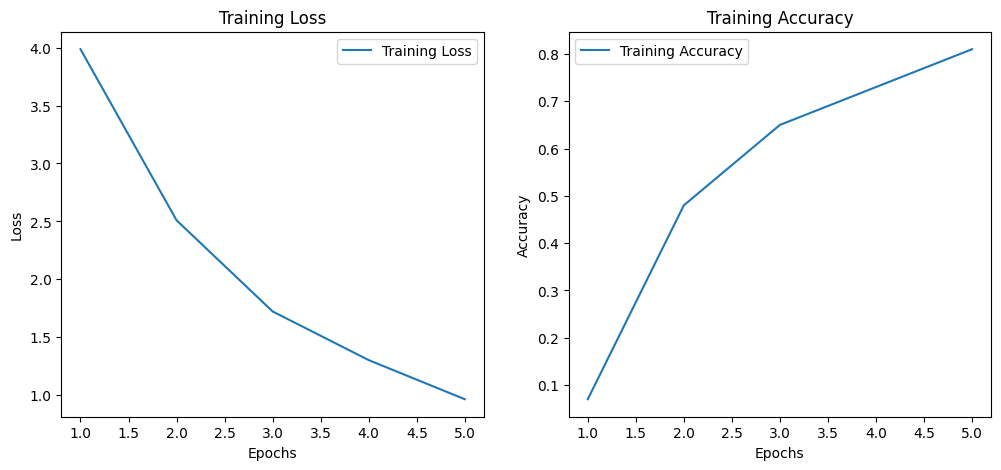

In [ ]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.show()

# Simulated loss and accuracy values for demonstration
train_losses = [3.9869, 2.5093, 1.7222, 1.3020, 0.9642]
train_accuracies = [0.07, 0.48, 0.65, 0.73, 0.81]

plot_metrics(train_losses, train_accuracies)

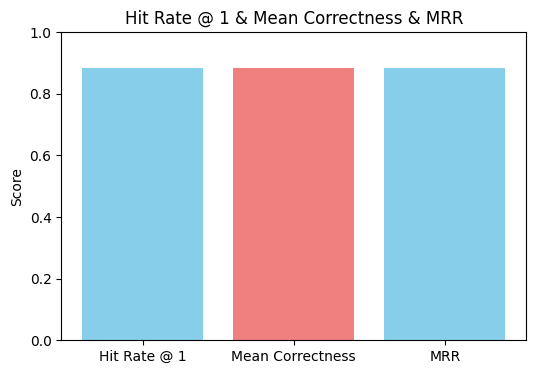

In [ ]:
import matplotlib.pyplot as plt

# 1. Visualizing Hit Rate and Mean Correctness
def visualize_hit_rate_mean_correctness(hit_rate, mean_correctness, mrr):
    metrics = ['Hit Rate @ 1', 'Mean Correctness', 'MRR']
    values = [hit_rate, mean_correctness, mrr]

    plt.figure(figsize=(6, 4))
    plt.bar(metrics, values, color=['skyblue', 'lightcoral'])
    plt.title('Hit Rate @ 1 & Mean Correctness & MRR')
    plt.ylabel('Score')
    plt.ylim([0, 1])
    plt.show()

hit_rate= 0.8839
mrr=0.8839
mean_correctness= 0.8839

# 1. Plot Hit Rate and Mean Correctness
visualize_hit_rate_mean_correctness(hit_rate, mean_correctness, mrr)